In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from graphviz import Digraph

# 自动求导

所有的机器学习框架（pytorch, tensorflow）等都提供自动求导计算引擎。自动求导是基于链式法则能够在进行计算后，通过反向传播得到每个输入参数的导数。

## 导数

导数计算公式为

$$
\frac{f(x+h)-f(x)}{h}
$$



[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


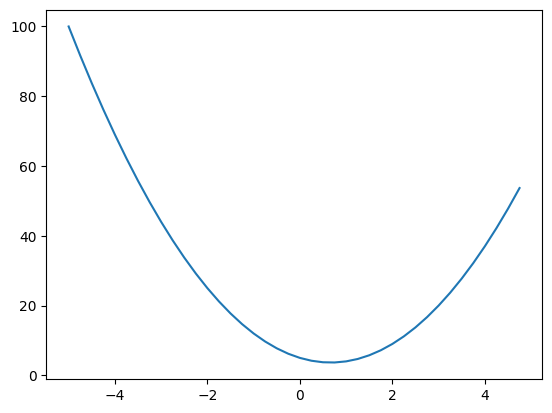

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25) # 以0.25为步长生成[-5, 5)范围内的数
ys = f(xs)
plt.plot(xs, ys)

计算$f(x)$在$x=\frac{2}{3}$处的导数

In [7]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

## 反向传播
计算图是在前向传递（forward）时生成，计算图是一个无环有向图。计算图在进行计算时，会将中间变量记录下来，以及对应的操作和求导函数，反向传播根据链式法计算叶节点的梯度。

$$
\frac{dL}{dx} = \frac{dL}{dz} \times \frac{dz}{dy} \times \frac{dy}{dx}
$$

In [29]:
class Value:
  
    def __init__(self, data, _children=(), _opi='', label=''):
        self.data = data
        self.grad = 0.0  # 初始梯度为0
        self._backward = lambda: None # 默认的反向传播函数为空
        self._prev = set(_children) # 上游节点
        self._op = _opi
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad # 梯度计算是累加的，因为上游节点可能抵达多个下游节点
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        
        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [18]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

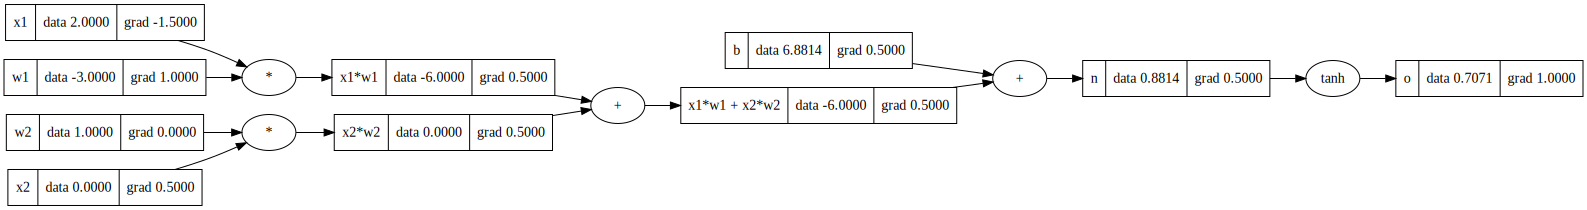

In [22]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

# 多层感知机（MLP）

In [30]:
class Neuron:
    def __init__(self, nin):
        '''
        nin表示特征的维度，使用随机值初始化权重和bias
        '''
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # 使用tanh作为激活函数
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    # MLP的一层，包含多个神经元
    # nin表示输入特征的维度，nout表示输出维度
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # 多层感知集，nin表示输入特征的维度，nouts表示每一层的输出维度
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [31]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 
n = MLP(3, [4, 4, 1])

训练一个模型，首先需要定一个损失函数（Loss），将训练集输入给模型后，通过损失函数计算模型输出和实际值的损失，接下来使用梯度下降法来对模型参数进行优化。

In [32]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 4.6081418532785055
1 2.3030051252911603
2 1.8320121242776435
3 1.0783773528097726
4 0.09657199517156963
5 0.05068146193613963
6 0.03712080444741189
7 0.02986780134327888
8 0.0252288281040971
9 0.021964112509133375
10 0.019522615216838346
11 0.01761770943026133
12 0.01608409058926617
13 0.014819122137840207
14 0.013755426744494537
15 0.012846797665999414
16 0.012060408801974622
17 0.01137225069421444
18 0.010764327317239699
19 0.010222865352661295
